<a href="https://colab.research.google.com/github/MalakOx/Brain-Tumor_-detection-localization-volume-estimation/blob/main/Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as KAA
from sklearn.preprocessing import StandardScaler, normalize

import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
import random
import numpy as np
import tensorflow as tf

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Healthcare AI Datasets/Brain_MRI


/content/drive/MyDrive/Healthcare AI Datasets/Brain_MRI


In [ ]:
brain_df = pd.read_csv('data_mask.csv')
brain_df['mask'] = brain_df['mask'].apply(lambda x: str(x))


In [ ]:
# split the data into train and test data
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df, test_size = 0.15)

In [ ]:
!pip install keras_preprocessing


In [ ]:
VAL_SPLIT = 0.15
IMAGE_SIZE = 256
IMAGE_CHAN = 3
BATCH_SIZE = 16

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255., validation_split = VAL_SPLIT)

In [ ]:



train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=BATCH_SIZE,
shuffle=True,
class_mode="categorical",
target_size=(IMAGE_SIZE,IMAGE_SIZE))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=BATCH_SIZE,
shuffle=True,
class_mode="categorical",
target_size=(IMAGE_SIZE,IMAGE_SIZE))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=BATCH_SIZE,
shuffle=False,
class_mode='categorical',
target_size=(IMAGE_SIZE,IMAGE_SIZE))

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHAN)))


In [ ]:
# freeze the model weights
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])


In [ ]:
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)


In [ ]:
class earlyStopAcc(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.99:
            self.model.stop_training = True
            print('Reached 99% accuracy, stopping training.')

callbacks = earlyStopAcc()

In [ ]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[callbacks,checkpointer])


In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)


In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)
len(predict)

In [ ]:
original = np.asarray(test['mask'])[:len(predict)]
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, predict)
accuracy

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours)
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

////////////////////

In [ ]:
brain_df_mask= pd.read_csv('brain_df_mask.csv')
brain_df_mask['mask'] = brain_df_mask['mask'].apply(lambda x: str(x))


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
#Create a list for imageId and classId to pass in the generator
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)


In [ ]:
import keras
class DataGenerator(keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size=32):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size

    def __len__(self):
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size : (idx + 1) * self.batch_size]

        # Load images and masks
        batch_x = np.array([cv2.imread(file_name) for file_name in batch_x]) / 255.0 # normalize images
        batch_y = np.array([cv2.imread(file_name, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0 for file_name in batch_y])

        return batch_x, batch_y

In [ ]:
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
def resblock(X, f):
  # make a copy of input
  X_copy = X

  # main path
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)
X_input = Input(input_shape)

conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

conv5_in = resblock(pool_4, 256)

up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )
model_seg.summary()

In [ ]:
from utilities import tversky


In [ ]:
import tensorflow as tf

@tf.function
def focal_tversky(y_true, y_pred):
    alpha = 0.7
    beta  = 0.3
    smooth = 1e-6

    # Flatten the inputs
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)

    # Calculate true positives, false positives, and false negatives
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    # Calculate Tversky score
    tversky_score = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)

    # Calculate focal Tversky loss
    focal_tversky_loss = tf.pow(1 - tversky_score, 0.5)

    return focal_tversky_loss

In [ ]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator, epochs = 150, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])


In [ ]:
with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
from utilities import prediction
image_id, mask, has_mask = prediction(test, model, model_seg)


In [ ]:
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

,image_path,predicted_mask,has_mask
0,TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...,"[[[[5.843522e-07], [2.0868015e-06], [4.203423e...",1
1,TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14...,No mask,0
2,TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19...,No mask,0
3,TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11...,No mask,0
4,TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54...,No mask,0
...,...,...,...
585,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_53...,No mask,0
586,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_12...,No mask,0
587,TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_10...,No mask,0
588,TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_17...,"[[[[9.464007e-07], [5.58997e-06], [1.0761594e-...",1


In [ ]:
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

,patient_id,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_FG_5962_20000626,TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...,TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...,1,"[[[[5.843522e-07], [2.0868015e-06], [4.203423e...",1
1,TCGA_DU_7306_19930512,TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14...,TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_14...,0,No mask,0
2,TCGA_FG_6692_20020606,TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19...,TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_19...,0,No mask,0
3,TCGA_DU_7013_19860523,TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11...,TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_11...,0,No mask,0
4,TCGA_DU_7304_19930325,TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54...,TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54...,0,No mask,0


In [ ]:
# Function to calculate tumor volume in cubic centimeters (cc)
def calculate_tumor_volume(predicted_mask):
    # Assuming the image resolution is 1 pixel = 1 mm^2 (you can adjust this according to your data)
    pixel_size = 1.0  # 1 pixel = 1 mm^2
    tumor_voxels = np.count_nonzero(predicted_mask)
    tumor_volume = tumor_voxels * pixel_size
    return tumor_volume


In [ ]:
tumor_volumes_cc = []
for i in range(len(df_pred)):
    if df_pred['has_mask'][i] == 1:
        predicted_mask = np.asarray(df_pred.predicted_mask[i]).squeeze().round()
        tumor_volume_cc = calculate_tumor_volume(predicted_mask)
        tumor_volumes_cc.append(tumor_volume_cc)
    else:
        tumor_volumes_cc.append(0.0)  # For images without a tumor, volume is set to 0.

df_pred['tumor_volume_cc'] = tumor_volumes_cc

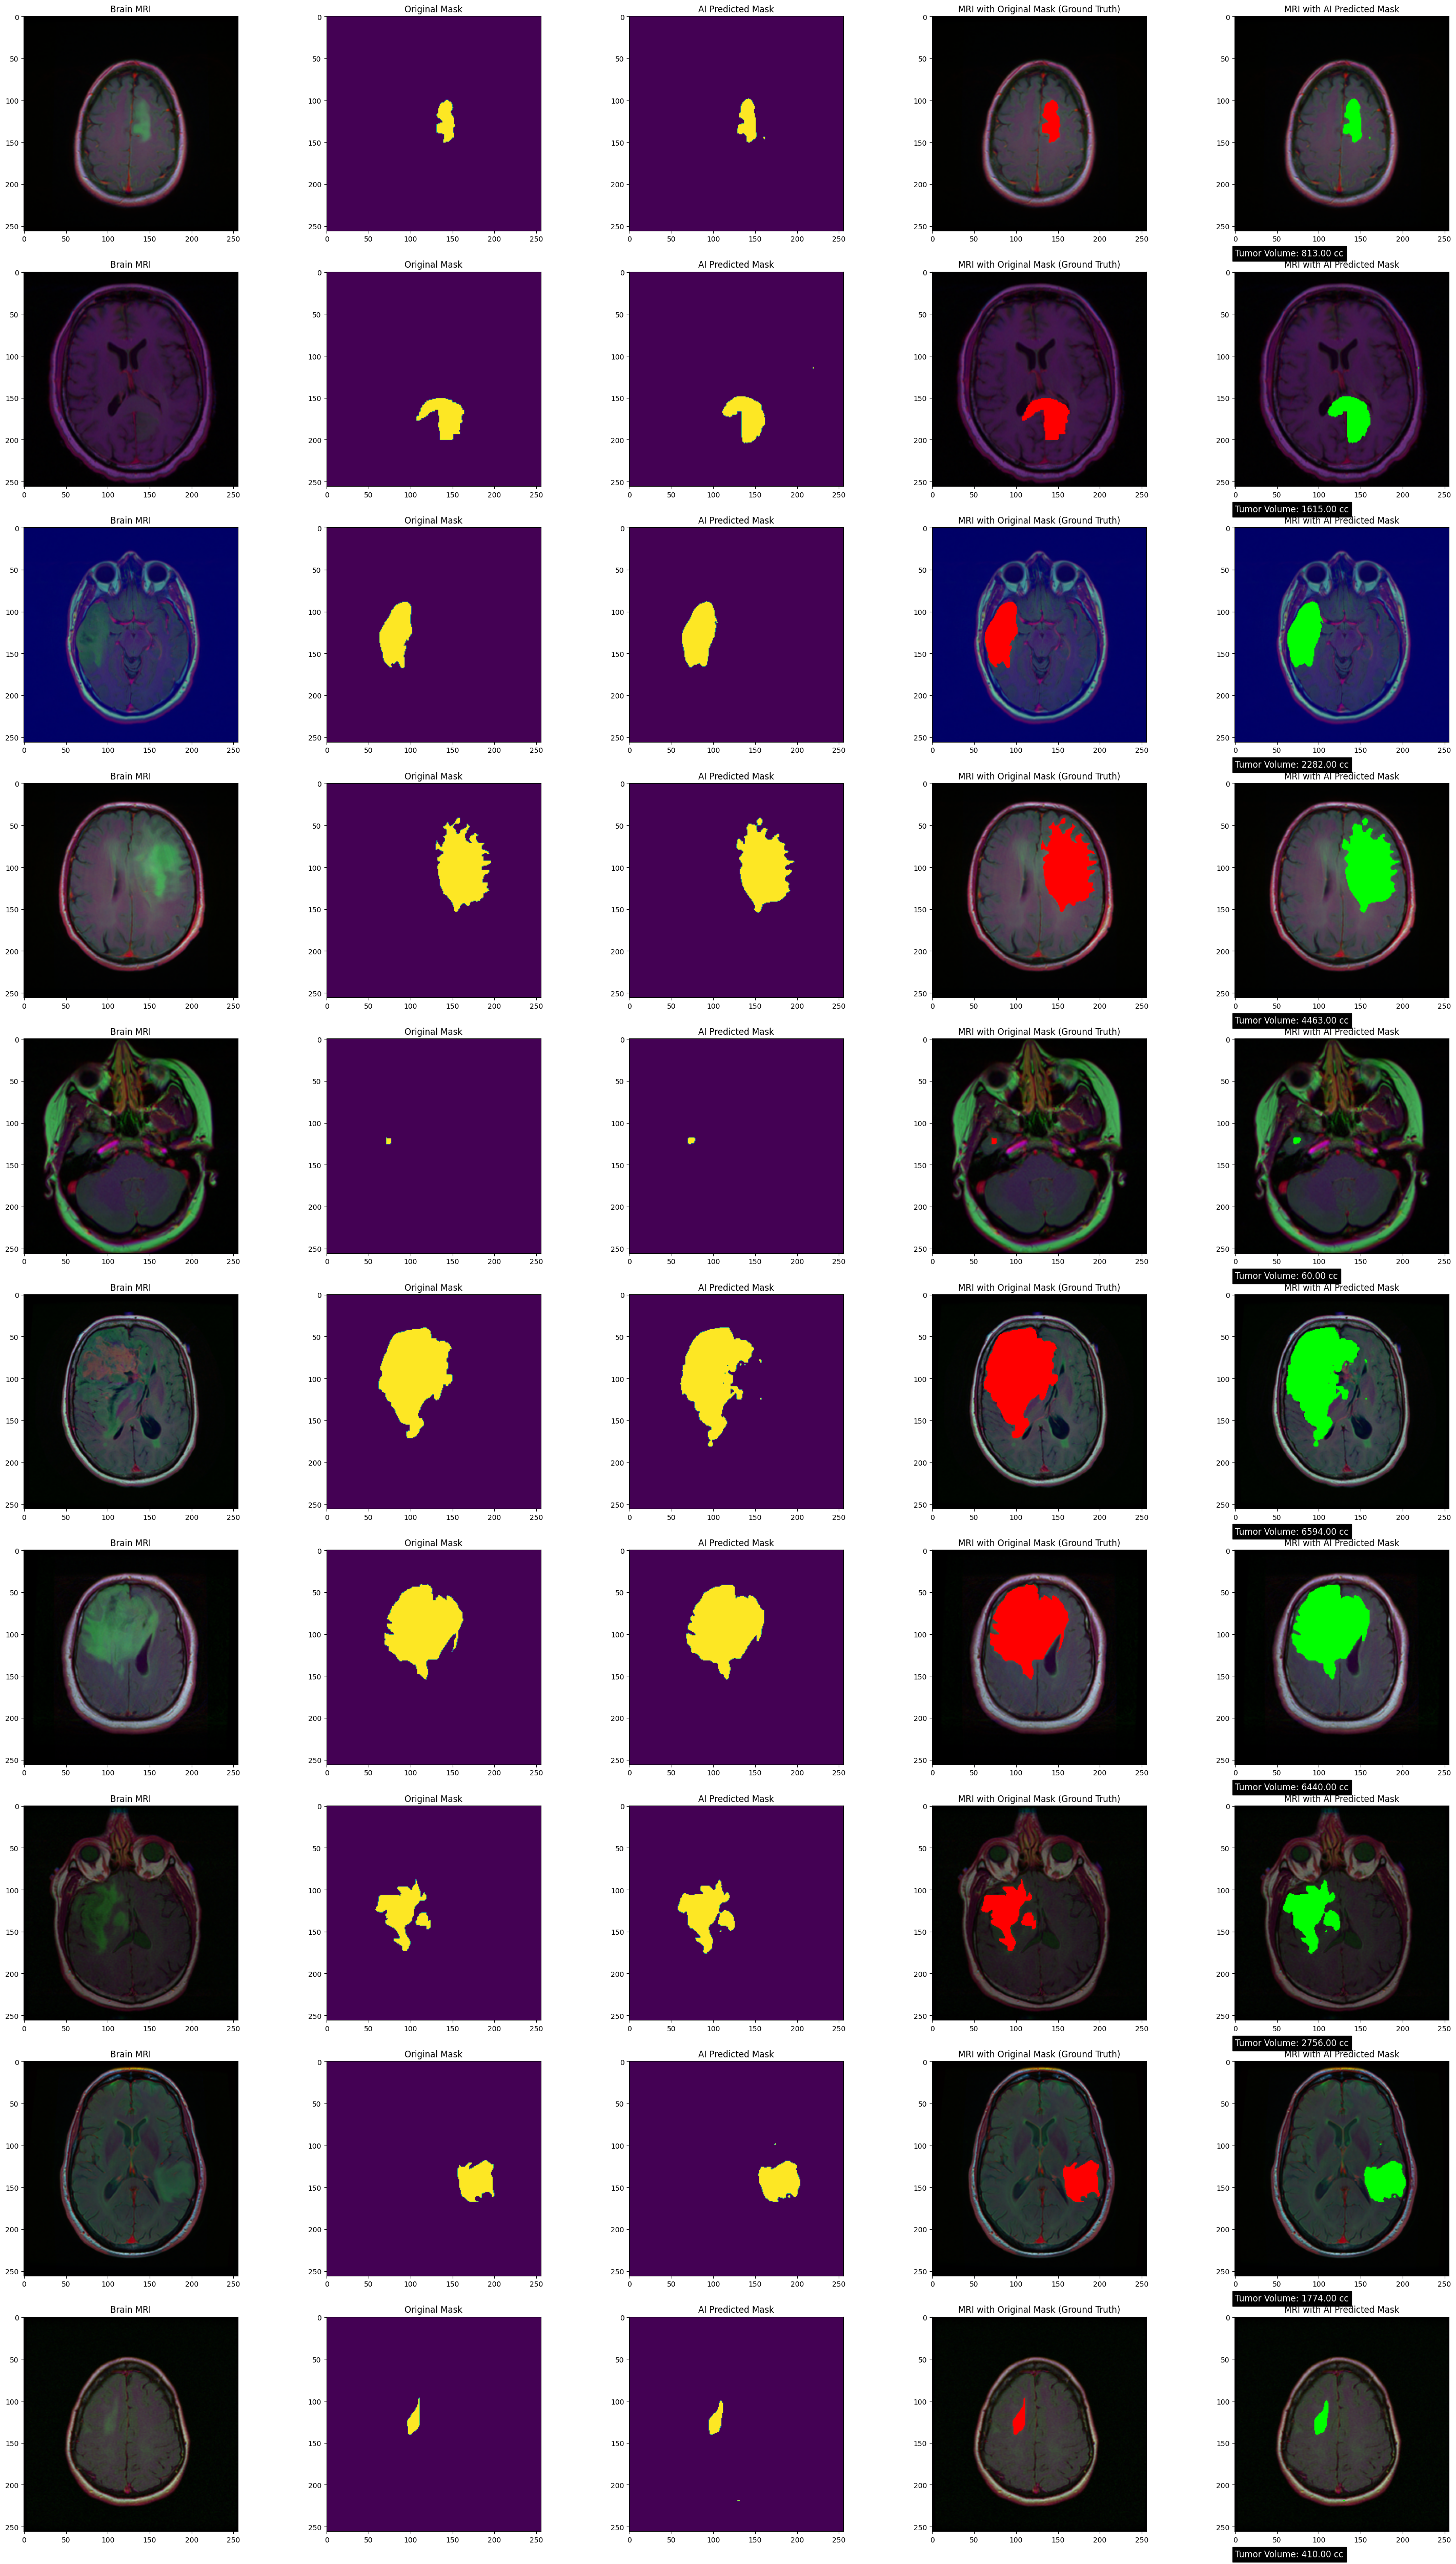

In [ ]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
    if df_pred['has_mask'][i] == 1 and count < 10:
        # Read the images and convert them to RGB format
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        # Obtain the mask for the image
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].title.set_text("Original Mask")
        axs[count][1].imshow(mask)

        # Obtain the predicted mask for the image
        predicted_mask = np.asarray(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].title.set_text("AI Predicted Mask")
        axs[count][2].imshow(predicted_mask)

        # Apply the mask to the image 'mask==255'
        img[mask == 255] = (255, 0, 0)
        axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
        axs[count][3].imshow(img)

        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[predicted_mask == 1] = (0, 255, 0)
        axs[count][4].title.set_text("MRI with AI Predicted Mask")
        axs[count][4].imshow(img_)

        # Get the tumor volume in cubic centimeters (cc)
        tumor_volume_cc = df_pred['tumor_volume_cc'][i]
        axs[count][4].text(0, img_.shape[0] + 30, f"Tumor Volume: {tumor_volume_cc:.2f} cc", fontsize=12, color='white', backgroundcolor='black')

        count += 1

fig.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the 'df_pred' DataFrame with 'image_path' and 'tumor_volume_cc' columns.

# Display the first 20 images and their tumor volume estimation in a table
num_images_to_display = 30

# Filter the DataFrame to include only images with a tumor
df_with_tumor = df_pred[df_pred['has_mask'] == 1]

# Take the first 20 rows (or less if there are fewer than 20 images with a tumor)
df_to_display = df_with_tumor.head(num_images_to_display)

# Create a table with image path and tumor volume
table_data = {
    'Image Path': df_to_display['image_path'],
    'Tumor Volume (cc)': df_to_display['tumor_volume_cc']
}

table_df = pd.DataFrame(table_data)

# Display the table
print(table_df)


                                           Image Path  Tumor Volume (cc)
0   TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17...              813.0
6   TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_21...             1615.0
13  TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_22...             2282.0
21  TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_15...             4463.0
23  TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_15...               60.0
24  TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_20...             6594.0
25  TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_14...             6440.0
29  TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_33...             2756.0
32  TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_11...             1774.0
35  TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_38...              410.0
37  TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_49...              520.0
38  TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_16...             1291.0
40  TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_21.